# Tarea 1
*Daniel Sierra B*

#Obtención de los datos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

Se descargan los datos de los edificios de tipo *retail* y se organizan en un solo dataset

In [ ]:
!wget http://en.openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/b710e97d-29c9-4ca5-8137-63b7cf447317/download/building1retail.csv
!wget http://en.openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/4d721c37-119c-43c8-a722-a36f5eea26c8/download/building2retail.csv
!wget http://en.openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/8a91474a-a20d-4dd2-b6a1-e5412a4e6c59/download/building3retail.csv
!wget http://en.openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/c9b11976-a906-4a41-80b0-7f4b81311a13/download/building4retail.csv
!wget http://en.openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/d31fa61c-def9-4142-b58d-27f434163892/download/building5retail.csv

In [ ]:
building1 = "/content/building1retail.csv"
building2 = "/content/building2retail.csv"
building3 = "/content/building3retail.csv"
building4 = "/content/building4retail.csv"
building5 = "/content/building5retail.csv"

In [ ]:
df_r1 = pd.read_csv(building1, index_col=[0], parse_dates=True)
df_r2 = pd.read_csv(building2, index_col=[0], parse_dates=True)
df_r3 = pd.read_csv(building3, index_col=[0], parse_dates=True)
df_r4 = pd.read_csv(building4, index_col=[0], parse_dates=True)
df_r5 = pd.read_csv(building5, index_col=[0], parse_dates=True)

df_retail = pd.concat([df_r1,df_r2,df_r3,df_r4,df_r5], axis=0)
df_retail

,OAT (F),Power (kW)
Timestamp,,
2010-01-01 01:15:00,51,165.1
2010-01-01 01:30:00,51,151.6
2010-01-01 01:45:00,51,146.9
2010-01-01 02:00:00,51,153.7
2010-01-01 02:15:00,51,153.8
...,...,...
2010-12-30 23:00:00,67,333.7
2010-12-30 23:15:00,68,221.0
2010-12-30 23:30:00,68,235.7


Se cambian los nombres de las columnas y del indice del dataset para facilitar el trabajo

In [ ]:
df_retail.columns = ['Temperatura','Potencia']
df_retail.index.names = ['Tiempo']
df_retail

,Temperatura,Potencia
Tiempo,,
2010-01-01 01:15:00,51,165.1
2010-01-01 01:30:00,51,151.6
2010-01-01 01:45:00,51,146.9
2010-01-01 02:00:00,51,153.7
2010-01-01 02:15:00,51,153.8
...,...,...
2010-12-30 23:00:00,67,333.7
2010-12-30 23:15:00,68,221.0
2010-12-30 23:30:00,68,235.7


# Exploración de datos

En primer lugar se buscan datos incompletos en el dataset, como en este caso no se encuantra ninguno no se realiza ningun procedimiento.

In [ ]:
df_retail.isnull().sum()

Temperatura    0
Potencia       0
dtype: int64

Se grafican los datos de cada columna en funcion del indice para observar el comportamiento de estos.

Text(0, 0.5, 'Potencia gastada (Kw)')

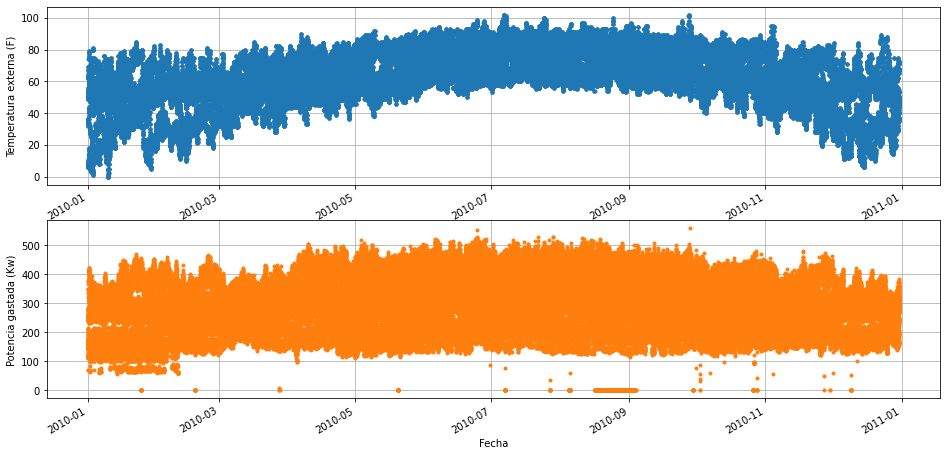

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)

df_retail['Temperatura'].plot(style='.')
plt.grid()
plt.xlabel('Fecha')
plt.ylabel('Temperatura externa (F)')

plt.subplot(2, 1, 2)
df_retail['Potencia'].plot(color='tab:orange',style='.')
plt.grid()
plt.xlabel('Fecha')
plt.ylabel('Potencia gastada (Kw)')

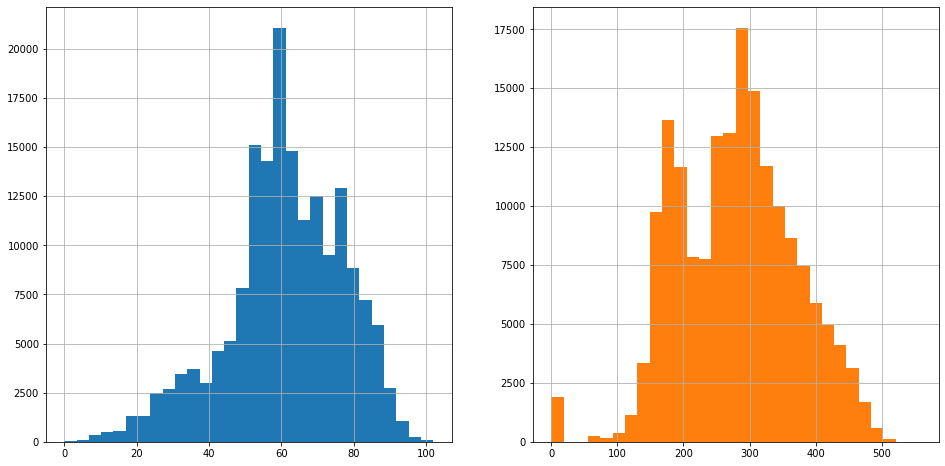

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
df_retail['Temperatura'].hist(bins=30)
plt.subplot(1, 2, 2)
df_retail['Potencia'].hist(bins=30,color='tab:orange')

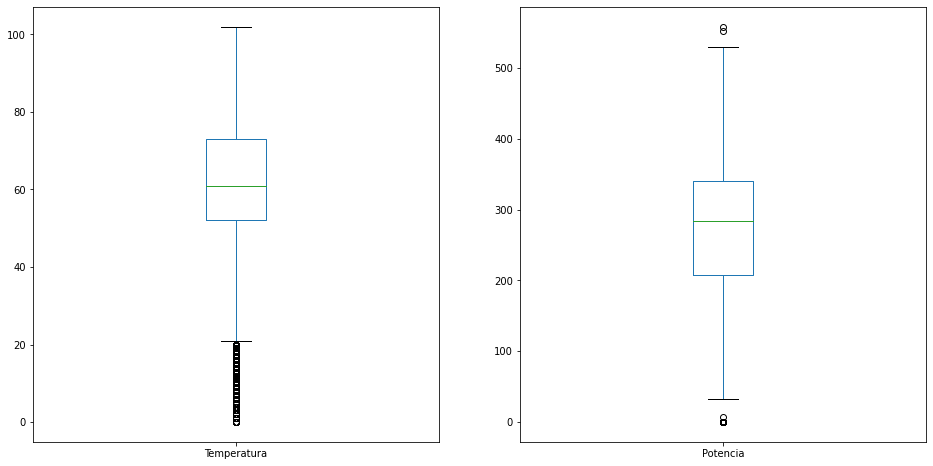

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
df_retail['Temperatura'].plot(kind='box', figsize=(16,8))
plt.subplot(1, 2, 2)
df_retail['Potencia'].plot(kind='box', figsize=(16,8))

En este caso se observa que ambos conjuntos de datos presentan un comportamiento *Gaussiano* con algunos datos muy alejados de la media de la distribucion (lo que llamamos *outliers*).

Por otra parte se puede observar una gran consentracion de datos con $Potencia = 0$ alrededor del mes de agosto del 2010, estos podrian significar el cierre de uno o varios de los edificios estudiados por esas fechas, en el proceso se tratara estos datos como *outliers* pero podria ser importante realizar un analisis posterior a estos datos.

#Limpieza

En este caso se utilizaran dos metodos para determinar que datos se consideran *outliers* primero se considerara que para nuestro modelo los datos siguen una distribucion gausiana y los datos fuera del limite de $3 \sigma$ se consideran *outliers* y son eliminados del dataset. Por otra parte se utilizara el metodo IQR (interquartile range) score donde se tiene en cuenta la diferencia entre el tercer y primer cuartil de la distribucion para definir un limite inferior y superior (usualmente no simetricos respecto a la media) donde todos los datos que se encuentren fuera de estos limites se considertan *outliers* y son eliminados del dataset.

##3 $\sigma$

Se eliminan los datos considerados outlier y se guarda la informacion enun nuevo dataset.

In [ ]:
df_3sig = df_retail[(np.abs(stats.zscore(df_retail)) < 3).any(axis=1)]
out_3sig = df_retail[(np.abs(stats.zscore(df_retail)) >= 3).any(axis=1)]

Se grafican los datos en contraste con los datos eliminados y se revisa la proporcil de estos para asegurarnos de no eliminar una fraccion muy grande de los datos ya que esto puede afectar el modelo de forma drastica.

Text(0, 0.5, 'Potencia gastada (Kw)')

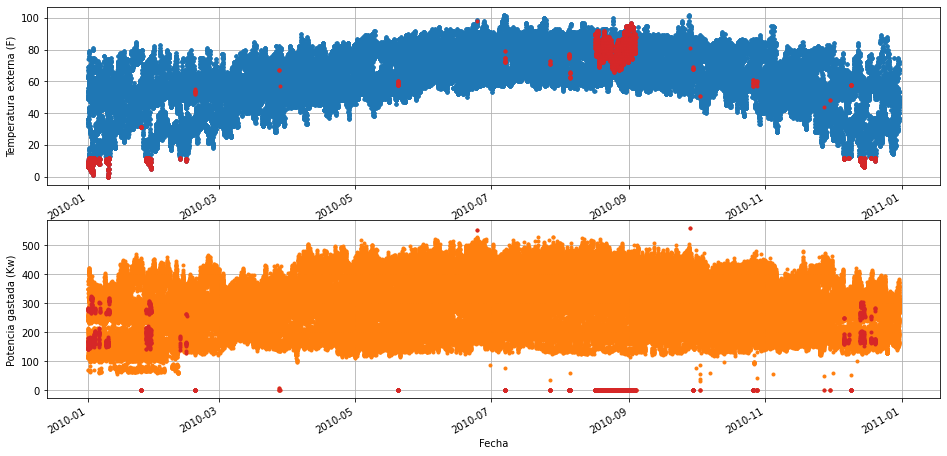

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)

df_3sig['Temperatura'].plot(style='.',grid=True)
out_3sig['Temperatura'].plot(color='tab:red',style='.')
plt.grid()
plt.xlabel('Fecha')
plt.ylabel('Temperatura externa (F)')

plt.subplot(2, 1, 2)
df_3sig['Potencia'].plot(color='tab:orange',style='.',grid=True)
out_3sig['Potencia'].plot(color='tab:red',style='.')
plt.grid()
plt.xlabel('Fecha')
plt.ylabel('Potencia gastada (Kw)')

In [ ]:
out_3sig.shape[0]/df_retail.shape[0]

0.015260446479679451

##IQR

Se repite el mismo proceso anterior solo que ahora el limite de los *outliers* esta dado por.

limite inferior:
$$ Q_1 - 1.5 * (Q_3 - Q_1) $$

limite superior:

$$ Q_3 + 1.5 * (Q_3 - Q_1) $$

In [ ]:
q1 = df_retail.quantile(0.25)
q3 = df_retail.quantile(0.75)

df_iqr = df_retail[(((df_retail > (q1 - 1.5*(q3-q1))) & (df_retail < (q3 + 1.5*(q3-q1)))).all(axis=1))]
out_iqr = df_retail[(((df_retail <= (q1 - 1.5*(q3-q1))) | (df_retail >= (q3 + 1.5*(q3-q1)))).any(axis=1))]

print(df_retail.shape)
print(df_iqr.shape)
print(out_iqr.shape)

(174700, 2)
(169914, 2)
(4786, 2)


Text(0, 0.5, 'Potencia gastada (Kw)')

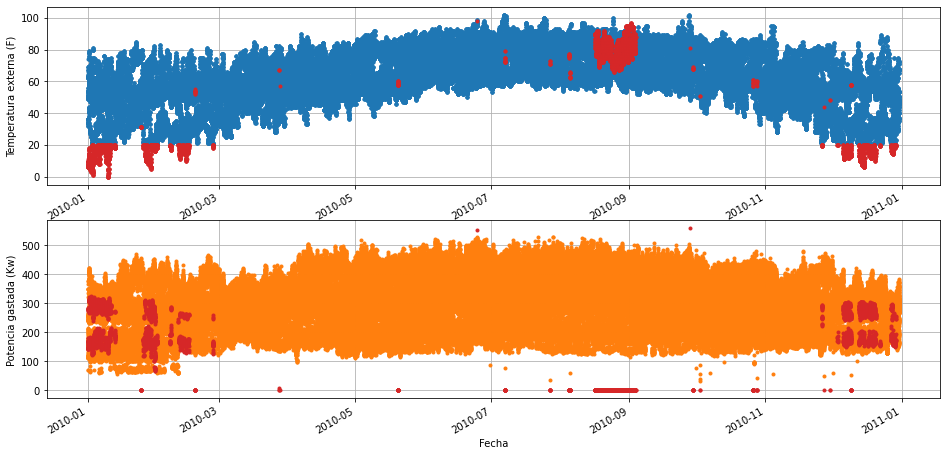

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)

df_iqr['Temperatura'].plot(style='.',grid=True)
out_iqr['Temperatura'].plot(color='tab:red',style='.')
plt.grid()
plt.xlabel('Fecha')
plt.ylabel('Temperatura externa (F)')

plt.subplot(2, 1, 2)
df_iqr['Potencia'].plot(color='tab:orange',style='.',grid=True)
out_iqr['Potencia'].plot(color='tab:red',style='.')
plt.grid()
plt.xlabel('Fecha')
plt.ylabel('Potencia gastada (Kw)')

In [ ]:
out_iqr.shape[0]/df_retail.shape[0]

0.027395535203205496

#Primer entrenamiento

Para este caso se asume un modelo donde la *Potencia* gastada por los edificios depende solamente de la temperatura externa.

In [ ]:
x_iqr = pd.DataFrame(df_iqr['Temperatura'])
y_iqr = pd.DataFrame(df_iqr['Potencia'])

x_train, x_test, y_train, y_test = train_test_split(x_iqr, y_iqr, test_size=0.33, random_state=42)

modelo_base = LinearRegression()
modelo_base.fit(x_train,y_train)

print(modelo_base.intercept_)
print(modelo_base.coef_)
print(modelo_base.score(x_test,y_test))

[79.85631995]
[[3.31314013]]
0.35109431965276755


Text(0, 0.5, 'Potencia gastada (Kw)')

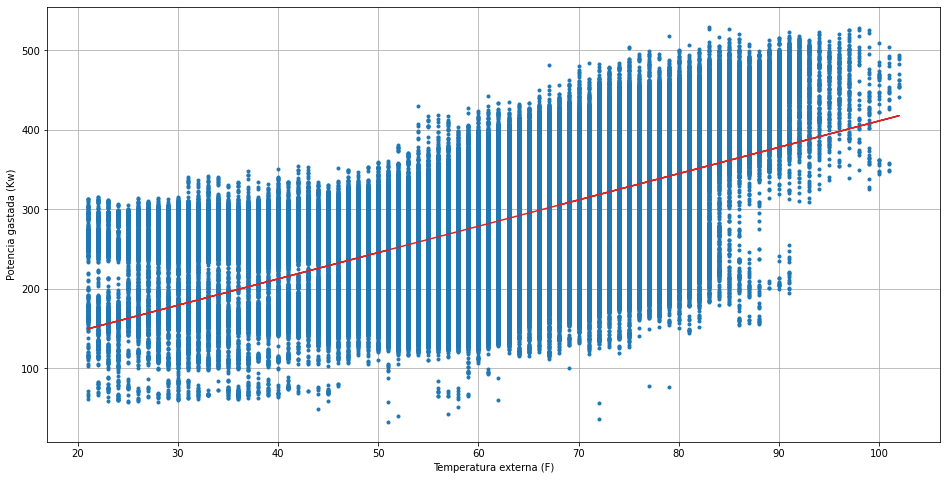

In [ ]:
y_mb = modelo_base.intercept_[0] + modelo_base.coef_[0][0] * x_iqr.values.flatten()

plt.figure(figsize=(16,8))
plt.grid()
plt.plot(x_iqr.values.flatten(),y_iqr.values.flatten(),'.')
plt.plot(x_iqr.values.flatten(),y_mb,color='tab:red')
plt.xlabel('Temperatura externa (F)')
plt.ylabel('Potencia gastada (Kw)')

Con esto obtenemos un modelo con un puntaje de 0.351 lo cual significa que este no es un muy buen modelo para describir la *Potencia* de energia usada por los edificios de tipo *retail*, con el fin de mejorar el modelo se observa la dependencia de la *potencia* en funcion de nuevos predictores generados apartir de los datos disponibles.

#Nuevos predictores

##Hora

En primer lugar se revisa un modelo donde la *Potencia* es una funcion de la *Temperatura* y de la hora del dia.

In [ ]:
df = df_iqr.copy()

In [ ]:
df['Hora'] = df.index.hour
df

,Temperatura,Potencia,Hora
Tiempo,,,
2010-01-01 01:15:00,51,165.1,1
2010-01-01 01:30:00,51,151.6,1
2010-01-01 01:45:00,51,146.9,1
2010-01-01 02:00:00,51,153.7,2
2010-01-01 02:15:00,51,153.8,2
...,...,...,...
2010-12-30 23:00:00,67,333.7,23
2010-12-30 23:15:00,68,221.0,23
2010-12-30 23:30:00,68,235.7,23


In [ ]:
x_h = pd.DataFrame(df[['Temperatura','Hora']])
y_h = pd.DataFrame(df['Potencia'])

x_train, x_test, y_train, y_test = train_test_split(x_h, y_h, test_size=0.33, random_state=42)

modelo_hora = LinearRegression()
modelo_hora.fit(x_train,y_train)

print(modelo_hora.intercept_)
print(modelo_hora.coef_)
print(modelo_hora.score(x_test,y_test))

[34.72850357]
[[2.91430919 6.03745254]]
0.596473450449427


Este modelo presenta una clara mejoria pasando a un puntaje de 0.596.

##Dia año

Por otra parte se revisan diferentes modelos donde la dependencia de la *Potencia* es una funcion de la *Temperatura* y el dia (evaluado en inter valos de año, mes y semana), no obstante estos modelos no representan una mejora significativa en la calidad del modelo ya que varian el puntaje de este muy poco con respecto el modelo inicial.

In [ ]:
df['Dia año'] = df.index.dayofyear
df

,Temperatura,Potencia,Hora,Dia mes,Dia semana,Dia año
Tiempo,,,,,,
2010-01-01 01:15:00,51,165.1,1,1,4,1
2010-01-01 01:30:00,51,151.6,1,1,4,1
2010-01-01 01:45:00,51,146.9,1,1,4,1
2010-01-01 02:00:00,51,153.7,2,1,4,1
2010-01-01 02:15:00,51,153.8,2,1,4,1
...,...,...,...,...,...,...
2010-12-30 23:00:00,67,333.7,23,30,3,364
2010-12-30 23:15:00,68,221.0,23,30,3,364
2010-12-30 23:30:00,68,235.7,23,30,3,364


In [ ]:
x_da = pd.DataFrame(df[['Temperatura','Dia año']])
y_da = pd.DataFrame(df['Potencia'])

x_train, x_test, y_train, y_test = train_test_split(x_da, y_da, test_size=0.33, random_state=42)

modelo_diaaño = LinearRegression()
modelo_diaaño.fit(x_train,y_train)

print(modelo_diaaño.intercept_)
print(modelo_diaaño.coef_)
print(modelo_diaaño.score(x_test,y_test))

[81.93131097]
[[ 3.33261099 -0.01792652]]
0.35157988645998606


##Dia mes

In [ ]:
df['Dia mes'] = df.index.day
df

,Temperatura,Potencia,Hora,Dia mes
Tiempo,,,,
2010-01-01 01:15:00,51,165.1,1,1
2010-01-01 01:30:00,51,151.6,1,1
2010-01-01 01:45:00,51,146.9,1,1
2010-01-01 02:00:00,51,153.7,2,1
2010-01-01 02:15:00,51,153.8,2,1
...,...,...,...,...
2010-12-30 23:00:00,67,333.7,23,30
2010-12-30 23:15:00,68,221.0,23,30
2010-12-30 23:30:00,68,235.7,23,30


In [ ]:
x_dm = pd.DataFrame(df[['Temperatura','Dia mes']])
y_dm = pd.DataFrame(df['Potencia'])

x_train, x_test, y_train, y_test = train_test_split(x_dm, y_dm, test_size=0.33, random_state=42)

modelo_diames = LinearRegression()
modelo_diames.fit(x_train,y_train)

print(modelo_diames.intercept_)
print(modelo_diames.coef_)
print(modelo_diames.score(x_test,y_test))

[81.8575559]
[[ 3.31491176 -0.13476464]]
0.3512490873858713


##Dia semana

In [ ]:
df['Dia semana'] = df.index.dayofweek
df

,Temperatura,Potencia,Hora,Dia mes,Dia semana
Tiempo,,,,,
2010-01-01 01:15:00,51,165.1,1,1,4
2010-01-01 01:30:00,51,151.6,1,1,4
2010-01-01 01:45:00,51,146.9,1,1,4
2010-01-01 02:00:00,51,153.7,2,1,4
2010-01-01 02:15:00,51,153.8,2,1,4
...,...,...,...,...,...
2010-12-30 23:00:00,67,333.7,23,30,3
2010-12-30 23:15:00,68,221.0,23,30,3
2010-12-30 23:30:00,68,235.7,23,30,3


In [ ]:
x_ds = pd.DataFrame(df[['Temperatura','Dia semana']])
y_ds = pd.DataFrame(df['Potencia'])

x_train, x_test, y_train, y_test = train_test_split(x_ds, y_ds, test_size=0.33, random_state=42)

modelo_dia = LinearRegression()
modelo_dia.fit(x_train,y_train)

print(modelo_dia.intercept_)
print(modelo_dia.coef_)
print(modelo_dia.score(x_test,y_test))

[81.70498014]
[[ 3.3133412  -0.62073446]]
0.3512620423312285


Esto nos permite observar que la *Potencia* esta bastante relacionada con la hora del dia por lo que tomaremos un dia cualquiera del año y graficaremos tanto la *Temperatura* como la *Potencia* en funcion de la hora del dia para observar su comportamiento mas detenidamente.

Text(0, 0.5, 'Potencia gastada (Kw)')

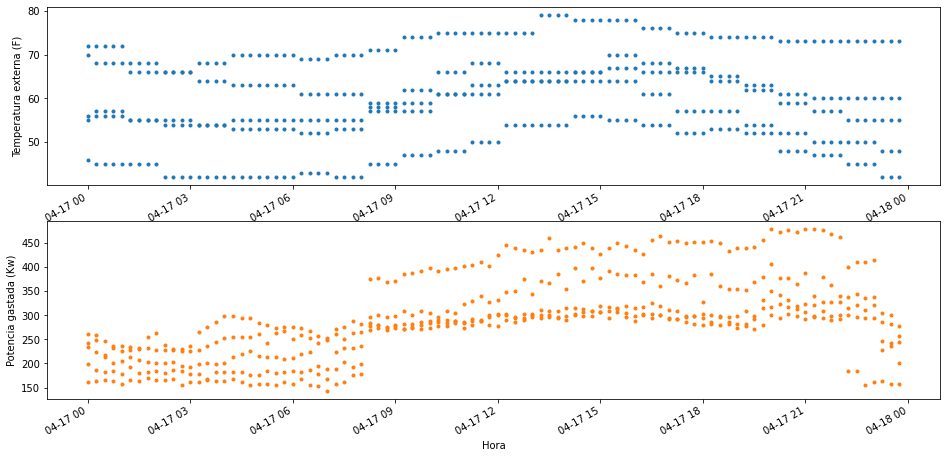

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(2, 1, 1)
df.loc['2010-04-17']['Temperatura'].plot(style='.',grid=True)
plt.grid()
plt.xlabel('Hora')
plt.ylabel('Temperatura externa (F)')

plt.subplot(2, 1, 2)
df.loc['2010-04-17']['Potencia'].plot(color='tab:orange',style='.',grid=True)
plt.grid()
plt.xlabel('Hora')
plt.ylabel('Potencia gastada (Kw)')

Con esto podemos observar que la *Potencia* presenta un aumento drastico entre las 8 y las 22, por lo que definiremos un nuevo predictor que definiremos coo *Horas laborales* que representara la diferencia entre este conjunto de horas y el resto, tomando un valor de 1 para el horario de 8 a 22 y 0 para el resto.

## Horas laborales

Teniendo esto en cuenta plateamos un modelos donde la *Potencia* esta dada en funcion de la *Temperatura* la *Hora* del dia y si esta hace parte del horario laboral o no.

In [ ]:
df['Horas laborales'] = np.where(((df['Hora'] >= 8) & (df['Hora'] <= 22)), 1, 0)
df

,Temperatura,Potencia,Hora,Dia mes,Dia semana,Dia año,Horas laborales
Tiempo,,,,,,,
2010-01-01 01:15:00,51,165.1,1,1,4,1,0
2010-01-01 01:30:00,51,151.6,1,1,4,1,0
2010-01-01 01:45:00,51,146.9,1,1,4,1,0
2010-01-01 02:00:00,51,153.7,2,1,4,1,0
2010-01-01 02:15:00,51,153.8,2,1,4,1,0
...,...,...,...,...,...,...,...
2010-12-30 23:00:00,67,333.7,23,30,3,364,0
2010-12-30 23:15:00,68,221.0,23,30,3,364,0
2010-12-30 23:30:00,68,235.7,23,30,3,364,0


In [ ]:
x_hhl = pd.DataFrame(df[['Temperatura','Hora','Horas laborales']])
y_hhl = pd.DataFrame(df['Potencia'])

x_train, x_test, y_train, y_test = train_test_split(x_hhl, y_hhl, test_size=0.33, random_state=42)

modelo_horahl = LinearRegression()
modelo_horahl.fit(x_train,y_train)

print(modelo_horahl.intercept_)
print(modelo_horahl.coef_)
print(modelo_horahl.score(x_test,y_test))

[41.58600536]
[[ 2.64200452  2.24350586 85.61544446]]
0.7288321865823105


De nuevo con este modelo se obtiene una mejoria significativa obteniendo un puntaje de 0.72 por lo que se podria cosiderar como el modelo final, no obstante revisaremos un modelo mas donde eliminaremos la dependencia de la *Hora* del dia y la *Potencia* solo sera funcion de la *Temperatura* y las *Horas laborales*

In [ ]:
x_hl = pd.DataFrame(df[['Temperatura','Horas laborales']])
y_hl = pd.DataFrame(df['Potencia'])

x_train, x_test, y_train, y_test = train_test_split(x_hl, y_hl, test_size=0.33, random_state=42)

modelo_horal = LinearRegression()
modelo_horal.fit(x_train,y_train)

print(modelo_horal.intercept_)
print(modelo_horal.coef_)
print(modelo_horal.score(x_test,y_test))

[53.16364112]
[[  2.66393841 106.28881291]]
0.7097468807372682


Finalmente obtenemos un modelo con un puntaje de 0.709 y una dependencia de 2 variables.